In [54]:
using Pkg
include("/cluster/home/danare/git/Clustering/TSClustering.jl")
cd("/cluster/home/danare/git/Clustering")
Pkg.activate(".")
using .TSClustering
using Distances
using Clustering
using DelimitedFiles
using DataFrames
using DynamicAxisWarping
using Dates
using Statistics
using CSV

  Activating project at `~/git/Clustering`


In [2]:

# config
path = "/cluster/home/danare/git/GENeSYS_MOD.data/Output/output_excel/Timeseries.xlsx"
config = "/cluster/home/danare/git/Clustering/data/config5.yml"
K = [1,2,3,4,5,7,8,9,10,11,12,13,20,30, 40,50,100]
W = Dict(
    "Euclidean" => 0,
   #"DTW (1)" => 1,
   # "DTW (2)" => 2,
   # "DTW (5)"  => 5,
    #"DTW (10)"  => 10,
    #"DTW (15)"  => 15,
    
);


# empty DataFrame
df = DataFrame(Cluster = Float64[], Window = Float64[], Value = Float64[])

# read in data
config = TSClustering.read_yaml_file(file=config);
data_org = TSClustering.read_data(path=path, config=config);
data_clustering_org = TSClustering.create_clustering_matrix(config=config, CountryData=data_org);
# apply normalization
data = TSClustering.normalize_data(CountryData=data_org, config=config);
data_clustering = TSClustering.create_clustering_matrix(config=config, CountryData=data);

# calculate the distance matrix
for w ∈ values(W)
    D = TSClustering.define_distance(w=w, data_clustering=data_clustering, fast_dtw=false)
    result = hclust(D, linkage=:ward)
    for k ∈ K 
        cl = cutree(result, k=k)
        weights = Dict()
        for i in cl
            weights[i] = get(weights, i, 0) + 1
        end
    
        # bring data in Jump format
        m_cluster_org, mapping_org_data = TSClustering.calculate_representative(representative=:medoid, data_clustering=data_clustering_org, cl=cl, weights=weights, k=k);
        cluster_dict_org = TSClustering.convert_data(k=k, config=config, M=m_cluster_org);
        data_org = TSClustering.read_data(path=path, config=config);
        sc = TSClustering.scaling(data_org=data_org, scaled_clusters=cluster_dict_org, k=k, weights=weights, config=config)
        # calculate rmse
        rmse = TSClustering.calculate_rmse(data_org=data_org, cluster_dict=sc, cl=cl)
        # insert new row dataframe 
        push!(df, [k w rmse])
    end 
end 

# write file as csv 


# plot 

TSClustering.plot_rmse_clusters(df=df, write_html=true, name=name="results/rmse_$(Dates.now()).html")


In [ ]:
TSClustering.plot_rmse_clusters(df=df, write_html=true, name=name="results/rmse_$(Dates.now()).html")


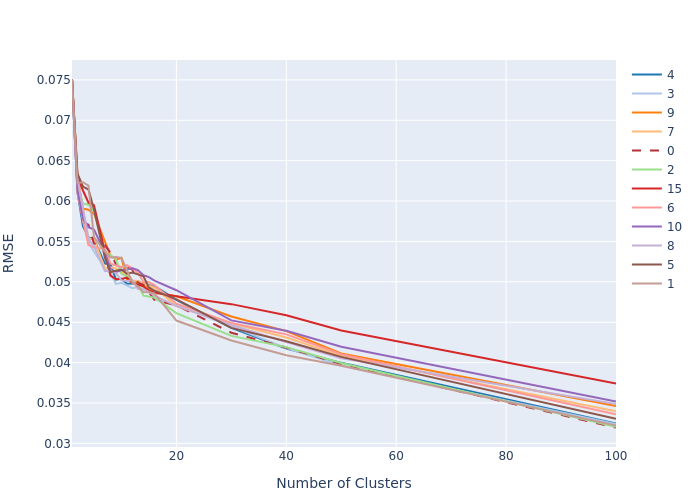

In [52]:
df = CSV.read("results/rmse_onenode.csv", DataFrame)
p = TSClustering.plot_rmse_clusters(df=df, write_html=false, name=name="results/rmse_$(Dates.now()).html")

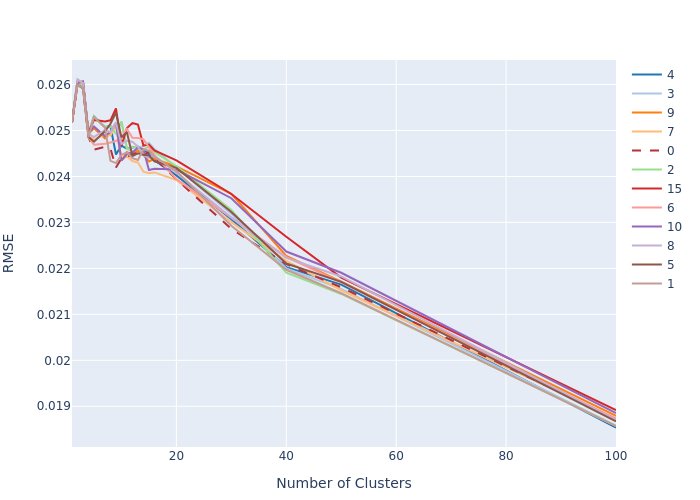

In [53]:
df = CSV.read("results/rmse_spatial.csv", DataFrame)
p = TSClustering.plot_rmse_clusters(df=df, write_html=false, name=name="results/rmse_$(Dates.now()).html")